In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv('IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Предобработка данных

### Токенизация и удаление стоп-слов 

In [3]:
# загружаем стоп-слова для английского

import nltk

nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Даниил\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# иницализируем токенайзер

word_tokenizer = nltk.WordPunctTokenizer()

In [5]:
# функция отбора слов 

import re
regex = re.compile(r'[А-Яа-яA-zёЁ-]+')

def words_only(text, regex=regex):
    try:
        return ' '.join(regex.findall(text)).lower()
    except:
        return ''

In [6]:
# функция первичной предобработки слов

def process_data(data):
    texts = []
    targets = []
    
    # поочередно проходим по всем отзывам в списке
    for item in data:
        
        text_lower = words_only(item) # оставим только слова
        tokens = word_tokenizer.tokenize(text_lower)
        
        # удаляем пунктуацию и стоп-слова
        tokens = [word for word in tokens if (word not in stop_words and not word.isnumeric())]
        
        texts.append(tokens) # добавляем в предобработанный список
        
    return texts

In [7]:
# запуск предобработки текста

y = df['sentiment']
texts = process_data(df['review'])

In [8]:
# результат предобработки

i = 1
print('Настроение: ', y[i])
print('Слова: ', texts[i][:5])

Настроение:  positive
Слова:  ['wonderful', 'little', 'production', 'br', 'br']


### Нормализация слов 

Для английского языка применим стеминг

In [9]:
# инициализируем стеммер

from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')

In [10]:
# применим стеммер ко всем текстам

for i in range(len(texts)):
    text_stemmer = [stemmer.stem(x) for x in texts[i]]
    texts[i] = ' '.join(text_stemmer)
    
    # преобразуем обработанный список слов в приложение
    
    texts[i] = ' '.join(texts[i].split())

In [11]:
# посмотрим на результат

i = 1
print('Настроение: ', y[i])
print('Обработанный текст: ', texts[i])

Настроение:  positive
Обработанный текст:  wonder littl product br br film techniqu unassum - old - time - bbc fashion give comfort sometim discomfort sens realism entir piec br br actor extrem well chosen - michael sheen got polari voic pat truli see seamless edit guid refer william diari entri well worth watch terrif written perform piec master product one great master comedi life br br realism realli come home littl thing fantasi guard rather use tradit dream techniqu remain solid disappear play knowledg sens particular scene concern orton halliwel set particular flat halliwel mural decor everi surfac terribl well done


#  Разбиваем на train&test

In [19]:
df['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

In [20]:
# Закодируем лейблы 0 и 1 через функцию

def label2num(y):
    if y == 'positive':
        return 1
    if y == 'negative':
        return 0
    
encoded_y = [label2num(yy) for yy in y]

        

In [21]:
# Разбиваем данные на train&test

from sklearn.model_selection import train_test_split

train_texts, test_texts, train_y, test_y = train_test_split(texts, encoded_y, test_size = 0.3,
                                                           random_state = 17, stratify = y)

# TF-IDF преобразование

In [54]:
df.shape

(50000, 2)

In [55]:
# инициализируем tf-idf

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features = 5000, norm = None) # возьмём топ 5000 слов
vectorizer.fit(train_texts)

TfidfVectorizer(max_features=5000, norm=None)

In [56]:
# Применим tf-idf преобразование

train_X = vectorizer.fit_transform(train_texts)
test_X = vectorizer.transform(test_texts)

# Логистическая регрессия

In [57]:
# Метрики качества

from sklearn.metrics import *

def quality_report(prediction, actual):
    print('Accuracy: {:.3f}\nPrecision: {:.3f}\nRecall: {:.3f}\nf1_score: {:.3f}'.format( 
         accuracy_score(prediction, actual),
         precision_score(prediction, actual),
         recall_score(prediction, actual),
         f1_score(prediction, actual)
    ))

In [58]:
def plot_roc_curve(prob_prediction, actual):
    fpr, tprm, thresholds = roc_curve(actual, prob_prediction)
    auc_score = roc_auc_score(actual, prob_prediction)
    
    plt.plot(fpr, tprm, label = 'ROC curve')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC: {:.3f}'.format(auc_score))
    plt.show()

In [59]:
# Обучаем линейную регрессию

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state = 17)

grid_params = {'C': [0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2', 'elasticnet', 'none']}

log_reg = GridSearchCV(model, 
                      grid_params,
                      cv = 5,
                      n_jobs = -1)

log_reg.fit(train_X, train_y)

print(f'Наилучшие параметры LogisticRegression {log_reg.best_params_}')

Наилучшие параметры LogisticRegression {'C': 0.01, 'penalty': 'l2'}


In [60]:
# Предсказание модели и вывод качества

log_reg_prediction = log_reg.best_estimator_.predict(test_X)

quality_report(log_reg_prediction, test_y)

Accuracy: 0.873
Precision: 0.879
Recall: 0.869
f1_score: 0.874


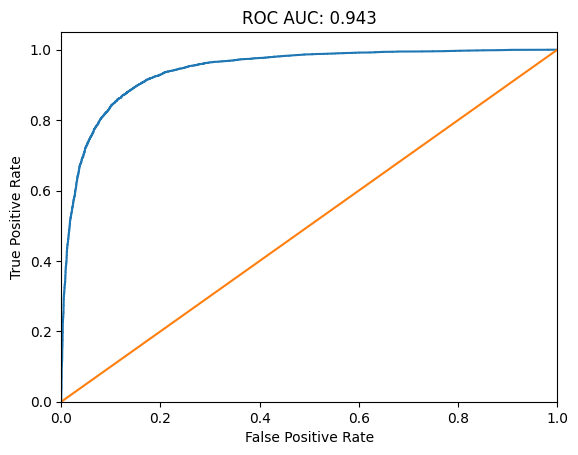

In [61]:
# Вывод метрики ROC-AUC

plot_roc_curve(log_reg.best_estimator_.predict_proba(test_X)[:, 1], test_y)

# Самые влиятельные коэффициенты регрессии

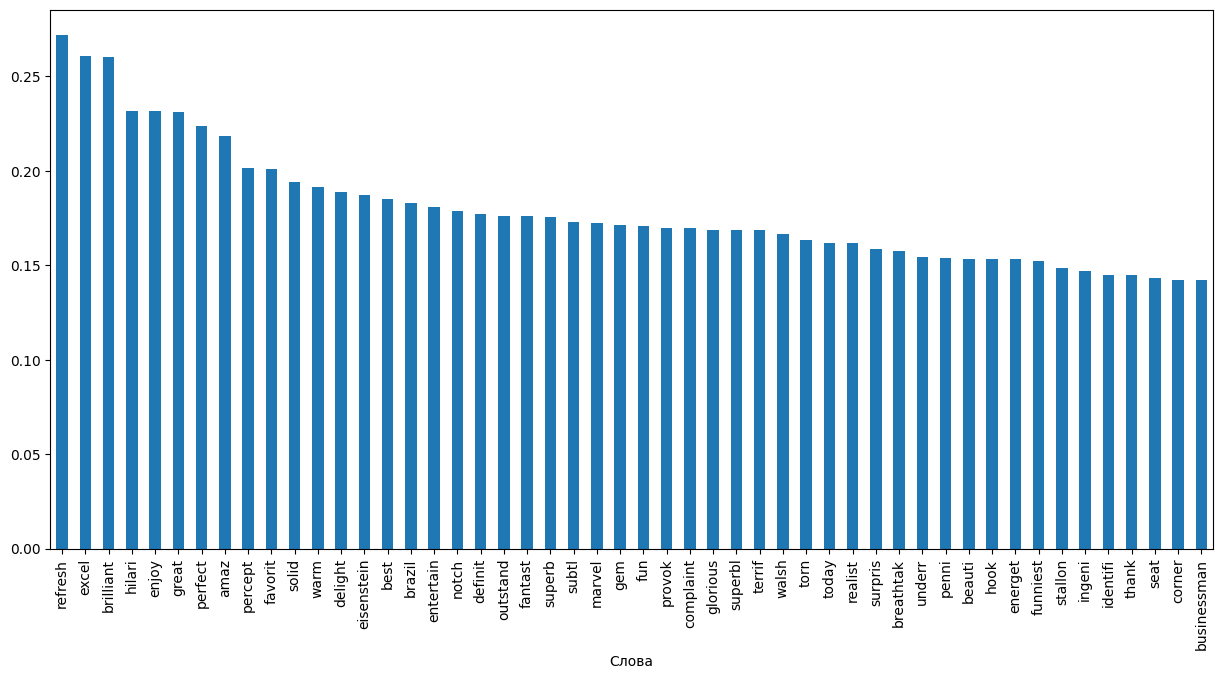

In [66]:

featureImportance = pd.DataFrame({'Слова': vectorizer.get_feature_names_out(),
                                 'Важность': log_reg.best_estimator_.coef_[0]})

featureImportance.set_index('Слова', inplace = True)
featureImportance.sort_values(['Важность'], ascending = False, inplace = True)
featureImportance['Важность'].head(50).plot(kind = 'bar', figsize = (15, 7));

Слова представленные на графике имеют большое влияние на настроение отзыва о фильме.